# Training Unsupervised Models
## 04_unsupervised_model_learning

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 28.09.2025   | Adrienne | Update | Creating models |
| 05.10.2025 | Adrienne | Update | Created baseline model with KMeans |
| 07.10.2025 | Adrienne | Update | Added code for wordcloud visualization |
| 12.10.2025 | Adrienne | Update | Finshing modeling using TF-IDF encoded data |
| 14.10.2025 | Adrienne | Update | Finished DBSCAN and Gaussian |
| 18.10.2025 | Adrienne | Update | Added feature importance plots |

# Content

* [Introduction](#introduction)

In [195]:

import pandas as pd
import numpy as np

# train test split
from sklearn.model_selection import train_test_split

# dimensionality reduction methods
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.manifold import TSNE

#unsupervised learning methods
# Feature agglomeration uses agglomerative(or hierarchical) clustering to group similar features, so it has its own dimensionality reduction technique
from sklearn.cluster import KMeans, AgglomerativeClustering, FeatureAgglomeration, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

# model selection
from sklearn.model_selection import GridSearchCV

# model scores
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score
import setuptools
from yellowbrick.cluster import SilhouetteVisualizer

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as cl
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import itertools

## Load Data

In [196]:
# readin in patient level file label encoded
path = "../data/clean"
df = pd.read_pickle(f"{path}/patient_level_features.pkl")

## Introduction - Model Development

We will create a baseline model using the label encoded patient level file.  Variations on the model will be added and then performance compared.  Initially, we encoded the data using labels, but when running the first Kmeans model, we realized that the missings created by that feature encoding method was not surprisingly giving very poor results.  We then switched to TD-IDF encoding and got much better and useful results.

### Creating Helper Functions

In [197]:
def standardize_features(dataset):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(dataset)
    return X_scaled

In [198]:
def dim_red_PCA(n_components, dataset):
    
    pca = PCA(n_components = n_components, random_state = 42)
    X_pca = pca.fit_transform(dataset)

# Calculate the explained variance ratio
    explained_variance_ = pca.explained_variance_
    explained_variance_ratio_ = pca.explained_variance_ratio_
    c_sum = np.cumsum(explained_variance_ratio_) 
    pc_components = np.arange(pca.n_components_) + 1
    c_sum_df = pd.DataFrame(zip(pc_components, c_sum), columns=['Principal Component', 'Cummulative Explained Variance'])
    print(c_sum_df)
    
    return pca, X_pca, explained_variance_ratio_, c_sum_df

In [199]:
def create_scree_plot(pca, explained_variance_, method ):
    eigenvalues = pca.explained_variance_
    prop_var = eigenvalues / np.sum(eigenvalues)
    pc_numbers = np.arange(pca.n_components_) + 1
    
    fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(10, 4))
    
    #plt.figure(figsize=(5, 4)) 
    ax1.plot(
             pc_numbers, 
             eigenvalues, 
            'b.-')
    
    ax1.axhline(y=1, color='r', linestyle='--')
    ax1.set_title('Figure 1: Scree Plot for Eigenvalues', fontsize=8)
    ax1.set_ylabel('Eigenvalues', fontsize=8)
    ax1.set_xlabel('Principal Component', fontsize=8)
    
#     ax1.set_xticks(fontsize=6)
#     ax1.set_yticks(fontsize=6)

    ax2.plot(
             pc_numbers, 
             prop_var, 
            'b.-')
    
    ax2.set_title('Figure 2: Scree Plot for Proportion of Variance Explained', fontsize=8)
    ax2.set_ylabel('Proportion of Variance Explained', fontsize=8)
    ax2.set_xlabel('Principal Component', fontsize=8)

    plt.show()
    
    return None 

In [200]:
def create_scree_plot(pca, explained_variance_ratio):
    
    pc_numbers = np.arange(pca.n_components_) + 1
    plt.figure(figsize=(5, 4)) 
    plt.plot(pc_numbers, 
            explained_variance_ratio, 
            'b.-')
    plt.title('Scree Plot', fontsize=10, weight='bold' )
    plt.ylabel('Proportion of Explained Variance', fontsize=8, weight='bold')
    plt.xticks(fontsize=8, weight = 'bold')
    plt.yticks(fontsize=8, weight = 'bold')
    plt.grid(color='lightgray', linewidth=0.5)
    plt.grid(axis='x')

    plt.show()
    plt.savefig("../assets/scree_plot.jpg")
    
    return None 

In [201]:
def feature_importance(pca, dataset):
    # number of components
    n_pcs= pca.components_.shape[0]

    # get the index of the most important feature on each component
    most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

    initial_feature_names = dataset.columns

    # get the names
    most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
    
    dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}
   
    return dic

In [202]:
def create_cluster_plot(labels, n_clusters, X_pca, model, axis, model_type):
      
    if model_type == 'dbscan':
            unique_labels = set(labels)
            n_clusters = len([l for l in unique_labels if l != -1])
             
    colors = cm.jet( (labels.astype(float) * 1.5 ) / (n_clusters))
    
    axis.scatter(
            X_pca[:, 0], X_pca[:, 1], 
            marker=".", 
            s=30, 
            lw=0, 
            alpha=0.7, 
            color = colors,
            edgecolor="k"
        )

    # Labeling the clusters
    if model_type == 'km':
        title = "K-Means Clustering Results"
        centers = model.cluster_centers_
    elif model_type == 'gmm':
        title = "Guassian Clustering Results"
        centers = model.means_

            
    # Draw white circles at cluster centers
    axis.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=100,
            edgecolor="k",
        )

    for i, c in enumerate(centers):
        cl = i * 1.5
        axis.scatter(c[0], c[1], 
                marker="$%d$" % (i + 1), 
                alpha=1, s=20, 
                color = cm.jet( (cl ) / (n_clusters)))
        axis.set_title(title)
        axis.set_xlabel("1st Feature space")
        axis.set_ylabel("2nd Feature space")
        axis.grid(False)
        
    plt.rcParams['axes.titlesize'] = 8
    plt.rcParams['axes.labelsize'] = 8
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

    plt.show()
    return None

In [203]:
def calculate_silhouette_score(X_pca, labels, metric, model_type):
    # works for all sklearn unsupervised model evaluation metrics with DBSCAN
        # Filter out noise for silhouette
    if model_type == 'dbscan':
        mask = labels != -1
        n_clusters = len(set(labels[mask]))

        if n_clusters > 1:
            score = silhouette_score(X_pca[mask], labels[mask], metric=metric)
    else:
        score = silhouette_score(X_pca, labels, metric= metric)
    #print(f'Silhouette Score using {metric} : %.3f {% score}')
    #print(f'Silhouette Score using {metric}: {score}')
    
    return score

In [204]:
def create_elbow_plot(cluster_range_start, cluster_range_end, X_pca):
    sse = []
    for i in range(cluster_range_start, cluster_range_end):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=5, random_state=42)
        kmeans.fit(X_pca)
        sse.append(kmeans.inertia_)

    plt.figure(figsize=(3, 3)) 
    plt.plot(range(cluster_range_start, cluster_range_end), sse)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

    plt.show()
    return None

### Baseline Model - KMeans
Steps: 
- standardize features
- reduce features using PCA
- use Scree plot to find optimal number of components
- create KMeans model
- find optimal number of clusters using Silhouette and Elbow methods
- examine most important feature by principal component
- create graph of clusters with first two principal components
- optimize any model inputs

## KMeans using TF-IDF Encoded Data

Standardizing Features

In [205]:
# Standardize the features
X_scaled = standardize_features(df)

Dimensionality Reduction using Principal Component Analysis

In [12]:
# Perform PCA using 24 components to see the cummulative explained variance
pca, X_pca, explaine_variance_ratio_, c_sum_df = dim_red_PCA(24, X_scaled)

    Principal Component  Cummulative Explained Variance
0                     1                        0.242001
1                     2                        0.351781
2                     3                        0.409579
3                     4                        0.465137
4                     5                        0.503952
5                     6                        0.538154
6                     7                        0.570440
7                     8                        0.600908
8                     9                        0.630056
9                    10                        0.657094
10                   11                        0.678230
11                   12                        0.697141
12                   13                        0.715623
13                   14                        0.733910
14                   15                        0.751780
15                   16                        0.769266
16                   17                        0

In [13]:
# calculating pca to use for scree plot
pca, X_pca, explained_variance_ratio_, c_sum_df = dim_red_PCA(14, X_scaled)

    Principal Component  Cummulative Explained Variance
0                     1                        0.242001
1                     2                        0.351781
2                     3                        0.409579
3                     4                        0.465137
4                     5                        0.503952
5                     6                        0.538154
6                     7                        0.570440
7                     8                        0.600908
8                     9                        0.630056
9                    10                        0.657094
10                   11                        0.678230
11                   12                        0.697141
12                   13                        0.715623
13                   14                        0.733910


Scree Plot - to Analyze Optimal PCA Components

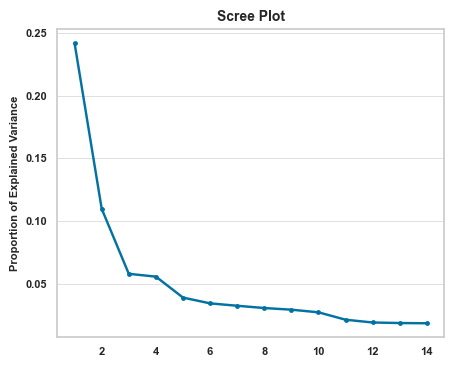

<Figure size 800x550 with 0 Axes>

In [14]:
create_scree_plot(pca, explained_variance_ratio_)

In [206]:
# final PCA as it explains more variance which we will risk it being overfitted
pca, X_pca, explained_variance_, c_sum_df = dim_red_PCA(11, X_scaled)

    Principal Component  Cummulative Explained Variance
0                     1                        0.242001
1                     2                        0.351781
2                     3                        0.409579
3                     4                        0.465137
4                     5                        0.503952
5                     6                        0.538154
6                     7                        0.570440
7                     8                        0.600908
8                     9                        0.630056
9                    10                        0.657094
10                   11                        0.678230


Create Silhouette Plots to optimize number of clusters and n_init

For n_clusters = 6 For n_init = 5 The average silhouette_score using euclidean is : 0.5774154651091128
For n_clusters = 6 For n_int =  5 The average silhouette_score using cosine is : 0.680411677944419


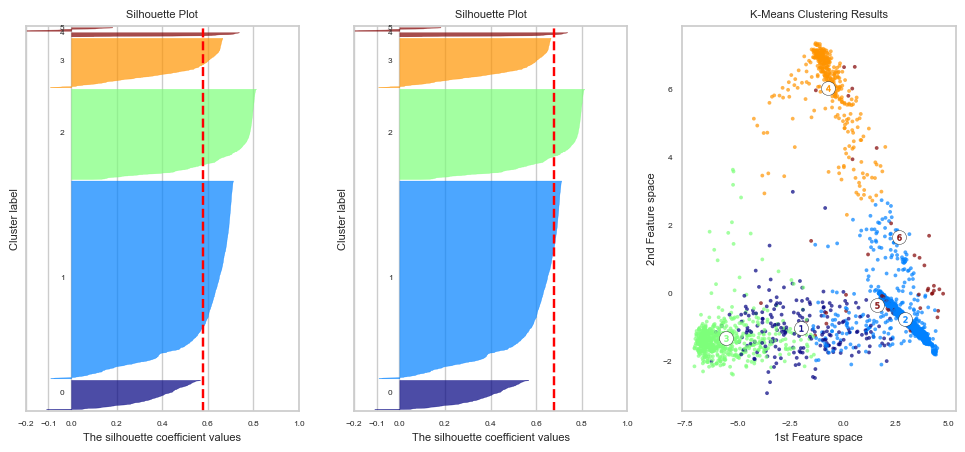

For n_clusters = 6 For n_init = 10 The average silhouette_score using euclidean is : 0.5774154651091128
For n_clusters = 6 For n_int =  10 The average silhouette_score using cosine is : 0.680411677944419


<Figure size 800x550 with 0 Axes>

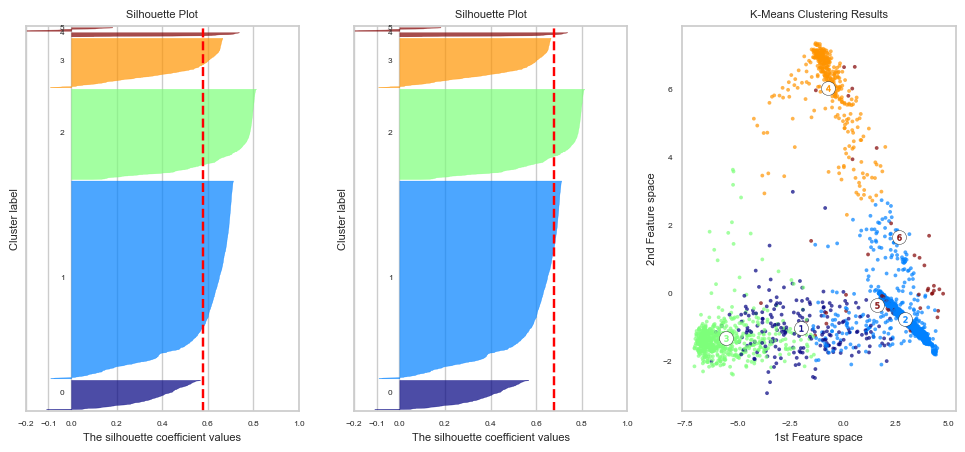

For n_clusters = 6 For n_init = 15 The average silhouette_score using euclidean is : 0.5774154651091128
For n_clusters = 6 For n_int =  15 The average silhouette_score using cosine is : 0.680411677944419


<Figure size 800x550 with 0 Axes>

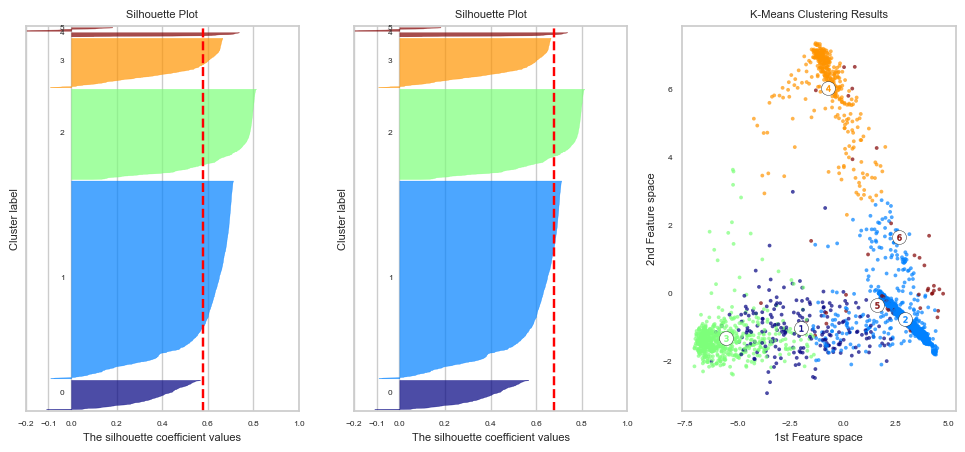

For n_clusters = 7 For n_init = 5 The average silhouette_score using euclidean is : 0.44336960197554015
For n_clusters = 7 For n_int =  5 The average silhouette_score using cosine is : 0.6398488171878784


<Figure size 800x550 with 0 Axes>

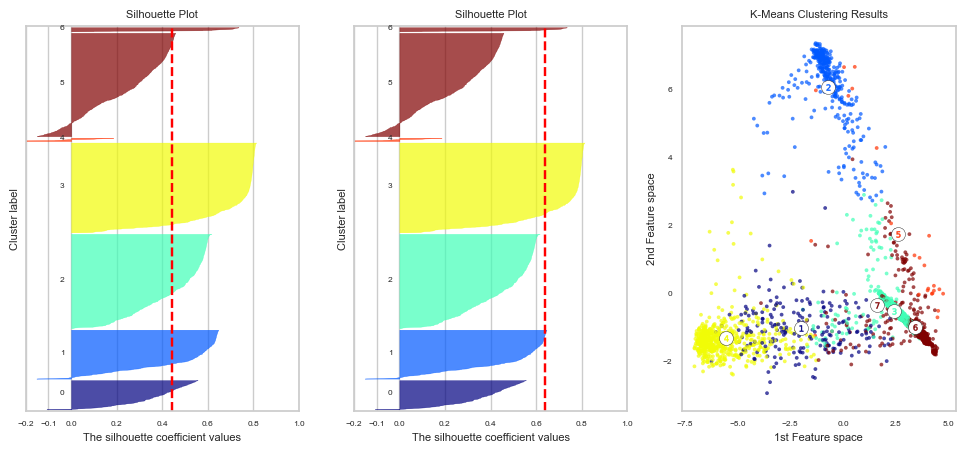

For n_clusters = 7 For n_init = 10 The average silhouette_score using euclidean is : 0.5982317828423174
For n_clusters = 7 For n_int =  10 The average silhouette_score using cosine is : 0.6994934657605104


<Figure size 800x550 with 0 Axes>

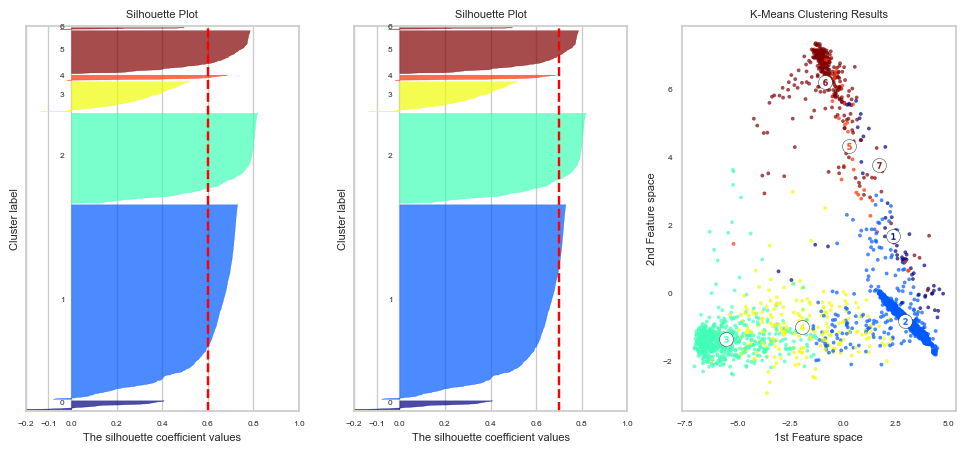

For n_clusters = 7 For n_init = 15 The average silhouette_score using euclidean is : 0.585481194960842
For n_clusters = 7 For n_int =  15 The average silhouette_score using cosine is : 0.6812508962089454


<Figure size 800x550 with 0 Axes>

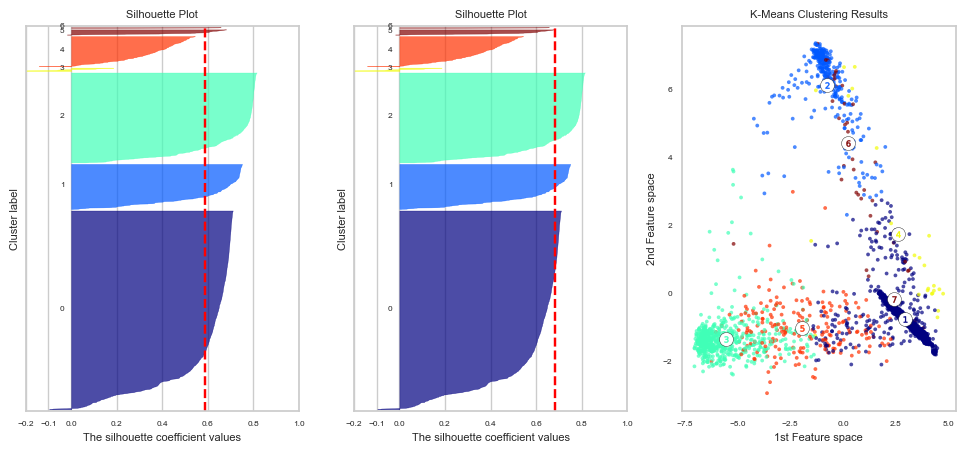

For n_clusters = 8 For n_init = 5 The average silhouette_score using euclidean is : 0.6119550520613942
For n_clusters = 8 For n_int =  5 The average silhouette_score using cosine is : 0.7029424243772361


<Figure size 800x550 with 0 Axes>

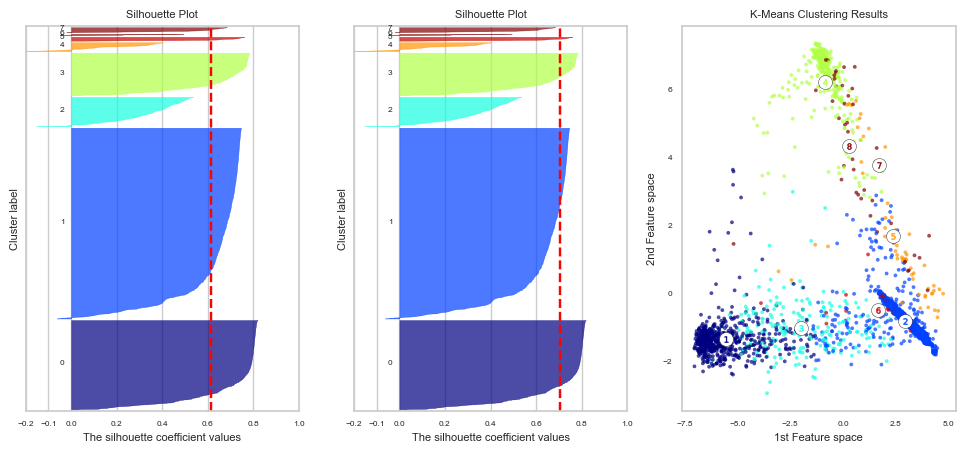

For n_clusters = 8 For n_init = 10 The average silhouette_score using euclidean is : 0.6119550520613942
For n_clusters = 8 For n_int =  10 The average silhouette_score using cosine is : 0.7029424243772361


<Figure size 800x550 with 0 Axes>

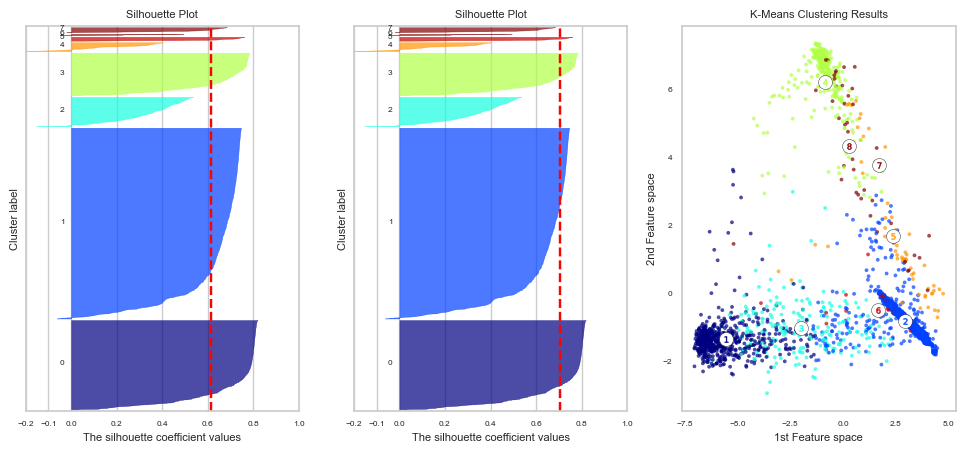

For n_clusters = 8 For n_init = 15 The average silhouette_score using euclidean is : 0.598599290814001
For n_clusters = 8 For n_int =  15 The average silhouette_score using cosine is : 0.6885711293549447


<Figure size 800x550 with 0 Axes>

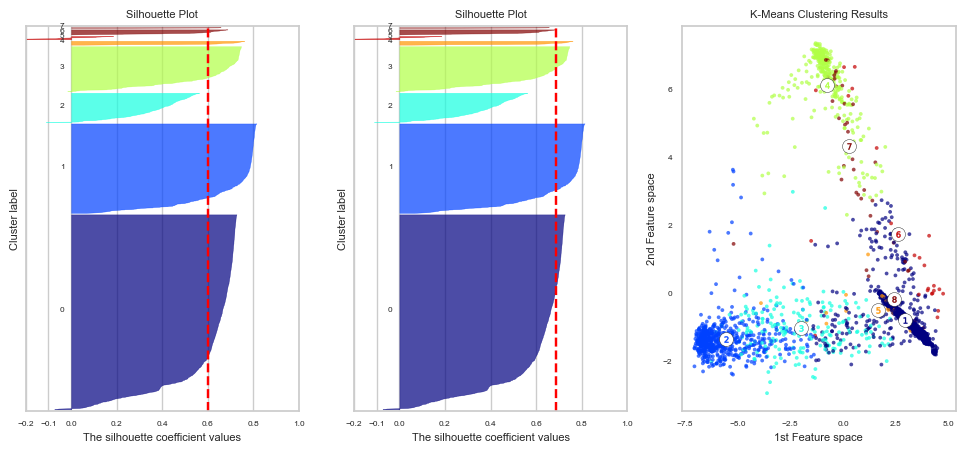

For n_clusters = 9 For n_init = 5 The average silhouette_score using euclidean is : 0.48605987851089005
For n_clusters = 9 For n_int =  5 The average silhouette_score using cosine is : 0.6753821909033746


<Figure size 800x550 with 0 Axes>

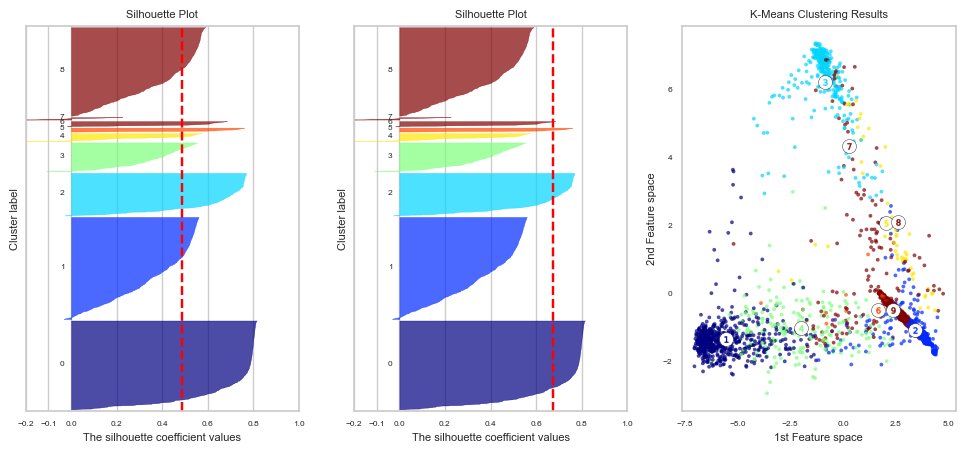

For n_clusters = 9 For n_init = 10 The average silhouette_score using euclidean is : 0.6177975569102752
For n_clusters = 9 For n_int =  10 The average silhouette_score using cosine is : 0.702416648211209


<Figure size 800x550 with 0 Axes>

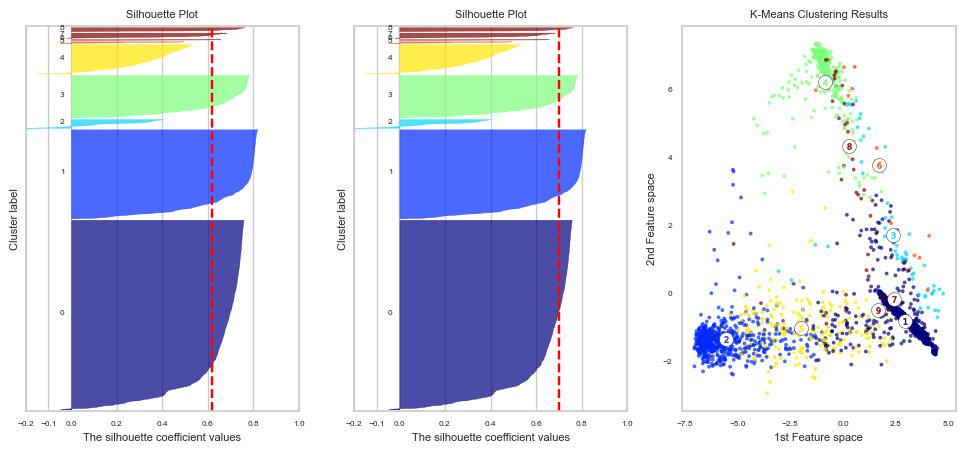

For n_clusters = 9 For n_init = 15 The average silhouette_score using euclidean is : 0.6177975569102752
For n_clusters = 9 For n_int =  15 The average silhouette_score using cosine is : 0.702416648211209


<Figure size 800x550 with 0 Axes>

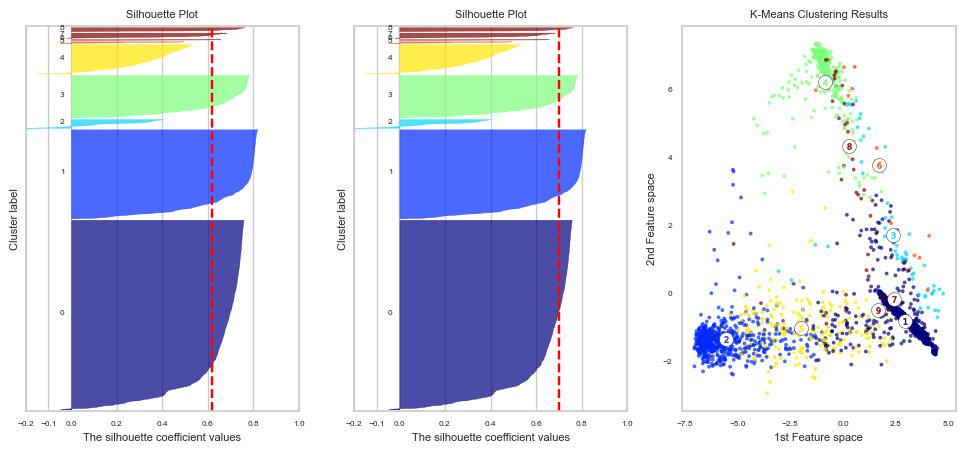

For n_clusters = 10 For n_init = 5 The average silhouette_score using euclidean is : 0.48906628728515616
For n_clusters = 10 For n_int =  5 The average silhouette_score using cosine is : 0.6744743524122209


<Figure size 800x550 with 0 Axes>

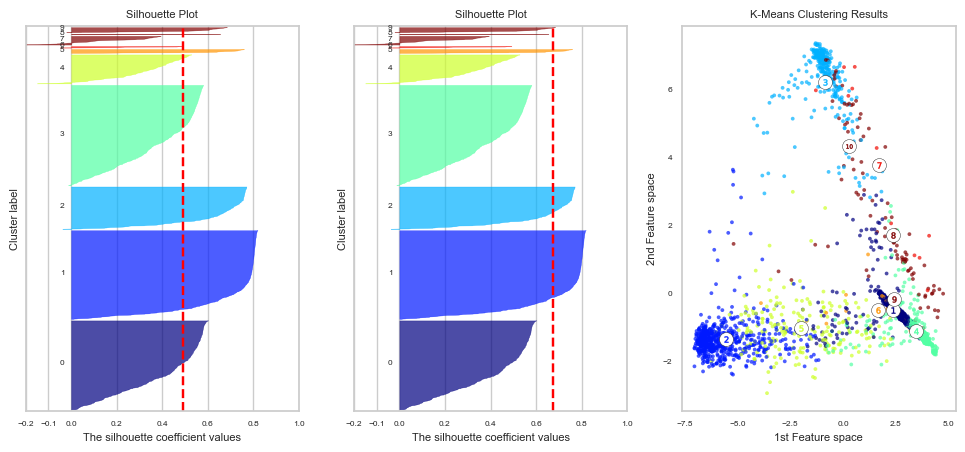

For n_clusters = 10 For n_init = 10 The average silhouette_score using euclidean is : 0.48906628728515616
For n_clusters = 10 For n_int =  10 The average silhouette_score using cosine is : 0.6744743524122209


<Figure size 800x550 with 0 Axes>

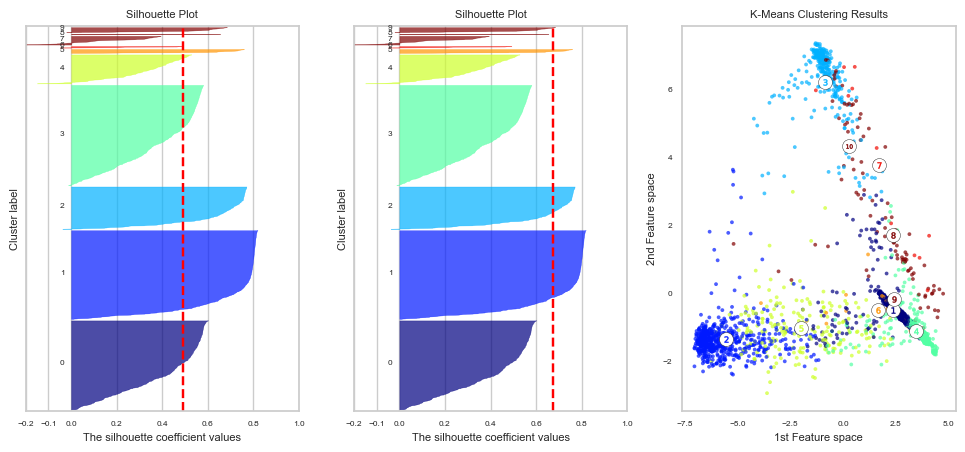

For n_clusters = 10 For n_init = 15 The average silhouette_score using euclidean is : 0.48906628728515616
For n_clusters = 10 For n_int =  15 The average silhouette_score using cosine is : 0.6744743524122209


<Figure size 800x550 with 0 Axes>

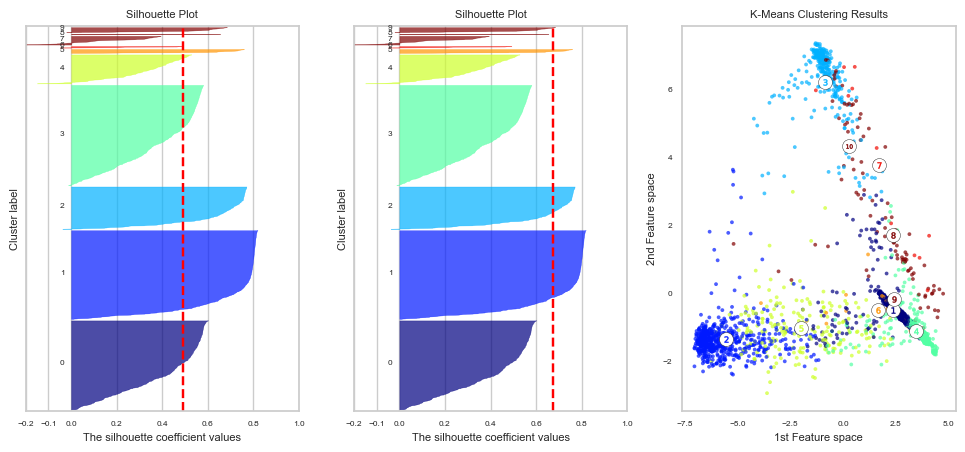

<Figure size 800x550 with 0 Axes>

In [211]:

range_n_clusters = [6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    for n_in in [5, 10, 15]:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(12, 5))
        
        # The 1st subplot is the silhouette plot
        ax1.set_xlim([-0.2, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots
        ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
        km = KMeans(init = 'k-means++', n_clusters=n_clusters, n_init = n_in, random_state=42)
        labels = km.fit_predict(X_pca)

        #silhouette_avg = silhouette_score(X_pca, cluster_labels)
        silhouette_avg = calculate_silhouette_score(X_pca, labels, 'euclidean', 'km')
        print(
            "For n_clusters =",
            n_clusters,
            "For n_init =",
            n_in,
            "The average silhouette_score using euclidean is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X_pca, labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            cl = float(i) * 1.5
            color = cm.jet( cl / (n_clusters))
            #color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize = 6)

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("Silhouette Plot")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.tick_params(axis='y', labelsize=6)
        ax1.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        ax1.tick_params(axis='x', labelsize=6)



    # The 1st subplot is the silhouette plot
        ax2.set_xlim([-0.2, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots
        ax2.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        km = KMeans(init = 'k-means++', n_clusters=n_clusters, n_init = n_in, random_state=42)
        labels = km.fit_predict(X_pca)

        #silhouette_avg = silhouette_score(X_pca, cluster_labels)
        silhouette_avg = calculate_silhouette_score(X_pca, labels, 'cosine', 'km')
        print(
            "For n_clusters =",
            n_clusters,
            "For n_int = ",
            n_in,
            "The average silhouette_score using cosine is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X_pca, labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            cl = float(i) * 1.5
            color = cm.jet( cl / (n_clusters))
            #color = cm.nipy_spectral(float(i) / n_clusters)
            ax2.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax2.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize = 6)

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax2.set_title("Silhouette Plot")
        ax2.set_xlabel("The silhouette coefficient values")
        ax2.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax2.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax2.set_yticks([])  # Clear the yaxis labels / ticks
        ax2.tick_params(axis='y', labelsize=6)
        ax2.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        ax2.tick_params(axis='x', labelsize=6)


        # 2nd Plot showing the actual clusters formed
        create_cluster_plot(labels, n_clusters, X_pca, km, ax3, model_type = 'km')

        plt.suptitle(
            "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=8,
            fontweight="bold",
        )

plt.show()

Elbow Method - did not have a good distinct elbow curve so silhouette plots were relied on instead

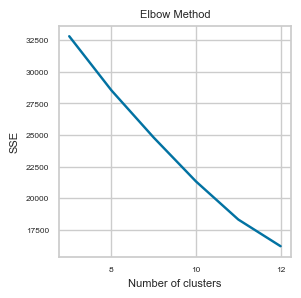

In [20]:
create_elbow_plot(7, 13, X_pca)

In [238]:
# from analysis using 8 clusters
kmeans = KMeans(init = 'k-means++', n_clusters=8, n_init= 5, random_state = 42) 
km = kmeans.fit(X_pca) 
labels = km.predict(X_pca)

# add cluster results to dataset
df['cluster'] = labels

In [239]:
# works for all sklearn unsupervised model evaluation metrics with DBSCAN
print(f"silhouette score using euclidean: {calculate_silhouette_score(X_pca, labels, 'euclidean', 'km')}")
print(f"silhouette score using cosine: {calculate_silhouette_score(X_pca, labels, 'cosine', 'km')}")

silhouette score using euclidean: 0.6119550520613942
silhouette score using cosine: 0.7029424243772361


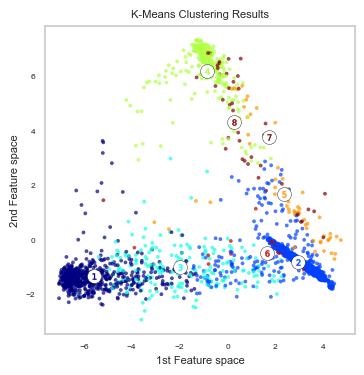

In [128]:
fig, ax = plt.subplots(figsize=(4, 4))
create_cluster_plot(labels, 8, X_pca, km, ax, model_type = 'km')

In [25]:
# quick look at cluster distribution
vals = df['cluster'].value_counts(normalize=True) * 100
pd.DataFrame({
  'cluster': vals
}).head(12)

,cluster
cluster,
1,51.285002
0,24.012275
3,11.507480
2,7.901803
4,2.416571
7,1.380898
5,1.074031
6,0.421941


Feature Importance

In [26]:
# Step 3: Feature importance from PCA
dic = feature_importance(pca, df)
dic

{'PC1': 'HCPCS_level_1',
 'PC2': 'S9126',
 'PC3': 'G8946',
 'PC4': 'H2000',
 'PC5': 'G0444',
 'PC6': 'T1502',
 'PC7': 'S9473',
 'PC8': 'S0605',
 'PC9': 'G0102',
 'PC10': 'C8928',
 'PC11': 'G9708'}

In [31]:
 n_pcs= pca.components_.shape[0]
 features = df.columns[0:-1]
 components = [(pca.components_[i]) for i in range(n_pcs)]
 df_comp = pd.DataFrame(components, columns = features)

In [194]:

fig, axes = plt.subplots(6, 2, figsize=(132, 75), sharex= True)
j = 0
k = 2
l = 0
for i in range(0,6):
    l = 0
    for component in range(j, k):
        #print(f"i {i} j {j} k {k} l {l}")
        if i == 5 and l == 1:
            #axes[i, l].grid(False)
            axes[i, l].set_visible(False)
            break
        ser = df_comp.iloc[component, :]
        dic = dict(zip(features, ser))
        dt_importance = dict(sorted(dic.items(), key=lambda item: abs(item[1])))
        dt = dict(itertools.islice(dt_importance .items(), 5))
        axes[i, l].barh(dt.keys(), dt.values())
        axes[i, l].set_title(f"PCA Feature Importance for Component {component}", fontsize = 55, fontweight = 'bold')
        axes[i, l].tick_params(axis='both', labelsize=45, rotation=45)
        #axes[i, l].grid(axis = 'y')
        l += 1 
    j += 2
    k += 2       


In [90]:
# save dataset
np.save(f"{path}/X_pca.npy", X_pca)
np.save(f"{path}/labels.npy", labels)
df.to_pickle(f"{path}/df_unsupervised_final.pkl")
dic_df.to_pickle(f"{path}/feature_ls.pkl")

### DBSCAN

In [335]:
n = pca.n_components_
neighbors = NearestNeighbors(n_neighbors=n)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)

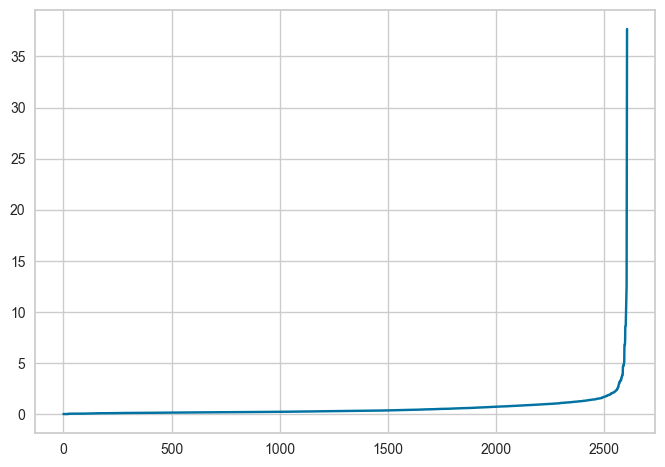

In [336]:
distances_el = np.sort(distances, axis=0)
distances_el = distances_el[:,1]
plt.plot(distances_el)

In [131]:
distances_el = np.sort(distances, axis=0)
distances_el = distances_el[:,1]
distances_el

array([ 0.        ,  0.        ,  0.        , ..., 12.57297102,
       29.95840605, 37.89710201], shape=(2607,))

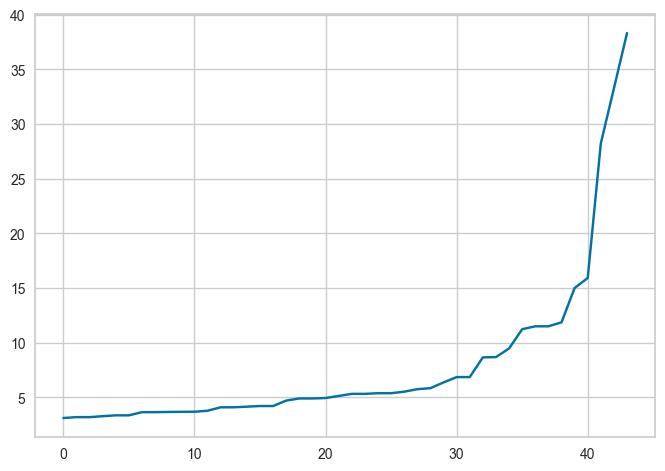

In [681]:
distances_el = np.sort(distances, axis=0)
distances_el = distances_el[:,1]
distances_el = distances_el[distances_el > 3]
plt.plot(distances_el)

In [337]:
param_grid = {'eps': [0.75, 1, 1.25, 1.5], 'min_samples': [5, 10, 15]} # easily add another parameter to this structure

for eps in param_grid['eps']:
    for min_sam in param_grid['min_samples']:
        dbscan = DBSCAN(eps=eps, min_samples=min_sam, metric='euclidean')
        labels = dbscan.fit_predict(X_pca)
        df['cluster'] = labels
        print(f'silhouette euclidean for eps {eps} and min_sample {min_sam}: {calculate_silhouette_score(X_pca, labels, 'euclidean', 'dbscan')}')
        print(f'silhouette cosine for eps {eps} and min_sample {min_sam}: {calculate_silhouette_score(X_pca, labels, 'cosine', 'dbscan')}')

silhouette euclidean for eps 0.75 and min_sample 5: 0.46297166860789246
silhouette cosine for eps 0.75 and min_sample 5: 0.5970896697113762
silhouette euclidean for eps 0.75 and min_sample 10: 0.7252957412644921
silhouette cosine for eps 0.75 and min_sample 10: 0.6998233082149314
silhouette euclidean for eps 0.75 and min_sample 15: 0.6176857122473006
silhouette cosine for eps 0.75 and min_sample 15: 0.5932557442367548
silhouette euclidean for eps 1 and min_sample 5: -0.16055116894748853
silhouette cosine for eps 1 and min_sample 5: -0.3272279773820161
silhouette euclidean for eps 1 and min_sample 10: 0.6203310319370448
silhouette cosine for eps 1 and min_sample 10: 0.6444474887991307
silhouette euclidean for eps 1 and min_sample 15: 0.7145700183660981
silhouette cosine for eps 1 and min_sample 15: 0.6880158610726612
silhouette euclidean for eps 1.25 and min_sample 5: -0.12694502009147418
silhouette cosine for eps 1.25 and min_sample 5: -0.4390036602547628
silhouette euclidean for eps 1

In [341]:
# testing cosine metric does not seem to work
# param_grid = {'eps': [0.75, 1, 1.25, 1.5], 'min_samples': [5, 10, 15], 'metric': ['euclidean', 'cosine']} # easily add another parameter to this structure


# for eps in param_grid['eps']:
#     for min_sam in param_grid['min_samples']:
#         for metric in param_grid['metric']:
#             dbscan = DBSCAN(eps=eps, min_samples=min_sam, metric = metric)
#             labels = dbscan.fit_predict(X_pca)
#             df['cluster'] = labels
#             print(f'silhouette euclidean for eps {eps} and min_sample {min_sam} and metric {metric}: {calculate_silhouette_score(X_pca, labels, 'euclidean', 'dbscan')}')
#             print(f'silhouette cosine for eps {eps} and min_sample {min_sam} and metric {metric}: {calculate_silhouette_score(X_pca, labels, 'cosine', 'dbscan')}')

In [146]:
dbscan = DBSCAN(eps = 0.75, min_samples=10, metric='euclidean')
labels = dbscan.fit_predict(X_pca)
df['cluster'] = labels

In [253]:
df['cluster'].value_counts()

cluster
 0    1108
-1     810
 3     479
 1     158
 4      27
 2      25
Name: count, dtype: int64

In [797]:
print(f"silhouette score using euclidean: {calculate_silhouette_score(X_pca, labels, 'euclidean', 'dbscan')}")
print(f"silhouette score using cosine: {calculate_silhouette_score(X_pca, labels, 'cosine', 'dbscan')}")

silhouette score using euclidean: 0.6926423996877238
silhouette score using cosine: 0.6347360520016123


Estimated number of clusters: 5
Estimated number of noise points: 810
{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(-1)}
(np.float64(0.0), np.float64(0.0), np.float64(0.5), np.float64(1.0))
(np.float64(0.0), np.float64(0.66078431372549), np.float64(1.0), np.float64(1.0))
(np.float64(0.7558507273877292), np.float64(1.0), np.float64(0.2118912080961417), np.float64(1.0))
(np.float64(1.0), np.float64(0.11692084241103862), np.float64(0.0), np.float64(1.0))
(np.float64(0.5), np.float64(0.0), np.float64(0.0), np.float64(1.0))
(np.float64(0.5), np.float64(0.0), np.float64(0.0), np.float64(1.0))


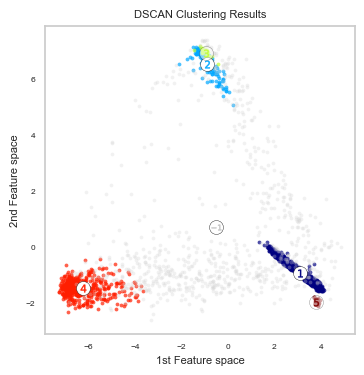

In [334]:

core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

# Number of clusters in labels, ignoring noise if present.
#n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_ = len(set(labels))
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % (n_clusters_ -1))
print('Estimated number of noise points: %d' % n_noise_)

#unique_labels = list(set(labels))[:-1]
unique_labels = set(labels)
print(unique_labels)
colors = [plt.cm.jet(each) for each in (np.linspace(0, 1, len(unique_labels) + 1 ) * 1.75)]
plt.figure(figsize=(4, 4))
for k, col in zip(unique_labels, colors):
    print(col)
    if k == -1:
        col = cl.to_rgba('lightgray')
        alpha = 0.3
    else:
        alpha = 0.7

    xy = X_pca[labels == k]
    #print(f" {len(xy)}")
    plt.scatter(xy[:, 0], xy[:, 1], 
        marker=".", 
        s=30, 
        lw=0, 
        alpha=alpha, 
        color = col,
        edgecolor="k"
    )

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = cl.to_rgba('silver')
    #print(k)
    center = []
    cluster_points = X_pca[labels == k]
    center.append(cluster_points.mean(axis=0))
    #print(f"0: {center[0][0]} 1: {center[0][1]}")
      
    if k == 2 or k == 4:
        alpha = 0.5
    else:
        alpha = 1
    # Draw white circles at cluster centers
    plt.scatter(
            center[0][0],
            center[0][1],
            marker="o",
            c="white",
            alpha=alpha,
            s=100,
            edgecolor="k",
    )        
    if k == -1:
        l = -1
        s = 50
    else:
        l = k + 1
        s = 30
    # add cluster label
    plt.scatter(center[0][0], center[0][1], 
            marker="$%d$" % (l), 
            alpha=1, s=s, 
                color = col)
    
plt.title("DSCAN Clustering Results")
plt.xlabel("1st Feature space")
plt.ylabel("2nd Feature space")
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
    
plt.grid(False)
plt.show()

### Guassian Mixture

In [140]:
param_grid = {'n_components': [7, 8, 9, 10], 'n_init': [5, 10, 15]} # easily add another parameter to this structure

for n_comp in param_grid['n_components']:
    for n_init in param_grid['n_init']:
        gmm = GaussianMixture(n_components = n_comp, random_state = 42, n_init = n_init)
        labels = gmm.fit_predict(X_pca)
        df['cluster'] = labels
        print(f'silhouette euclidean for n_components {n_comp} and n_init {n_init}: {calculate_silhouette_score(X_pca, labels, 'euclidean', 'gmm')}')
        print(f'silhouette cosine for n_components {n_comp} and n_init {n_init}: {calculate_silhouette_score(X_pca, labels, 'cosine', 'gmm')}')

silhouette euclidean for n_components 7 and n_init 5: 0.4217556280851098
silhouette cosine for n_components 7 and n_init 5: 0.4423134963987019
silhouette euclidean for n_components 7 and n_init 10: 0.4217556280851098
silhouette cosine for n_components 7 and n_init 10: 0.4423134963987019
silhouette euclidean for n_components 7 and n_init 15: 0.4217556280851098
silhouette cosine for n_components 7 and n_init 15: 0.4423134963987019
silhouette euclidean for n_components 8 and n_init 5: 0.4263172388625651
silhouette cosine for n_components 8 and n_init 5: 0.3996956005261978
silhouette euclidean for n_components 8 and n_init 10: 0.37570231708403345
silhouette cosine for n_components 8 and n_init 10: 0.3715685716939244
silhouette euclidean for n_components 8 and n_init 15: 0.42720025747858253
silhouette cosine for n_components 8 and n_init 15: 0.44766114744515495
silhouette euclidean for n_components 9 and n_init 5: 0.395445118182402
silhouette cosine for n_components 9 and n_init 5: 0.338523

In [141]:
# Step 4: Fit GMM model
gmm = GaussianMixture(n_components=8, random_state=42, n_init=15)
gmm.fit(X_pca)
labels = gmm.predict(X_pca)

# Step 5: Add cluster labels to dataset
df['cluster'] = labels

# Step 6: Cluster distribution summary
vals = df['cluster'].value_counts(normalize=True) * 100
pd.DataFrame({'cluster': vals}).head(12)

,cluster
cluster,
2,41.925585
7,19.754507
1,18.910625
4,8.323744
5,3.720752
6,3.682394
0,2.378213
3,1.304181


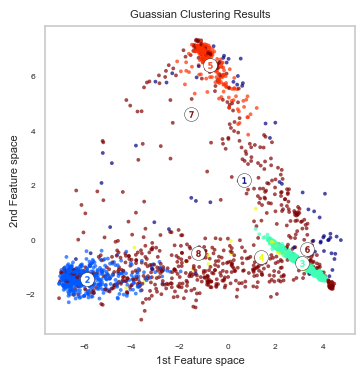

In [143]:
fig, ax = plt.subplots(figsize=(4, 4))
create_cluster_plot(labels, 7, X_pca, gmm, ax, 'gmm')

In [801]:
print(f'silhouette euclidean for n_components 8 and n_init 15: {calculate_silhouette_score(X_pca, labels, 'euclidean', 'gmm')}')
print(f'silhouette cosine for n_components 8 and n_init 15: {calculate_silhouette_score(X_pca, labels, 'cosine', 'gmm')}')

silhouette euclidean for n_components 8 and n_init 15: 0.4272002574785839
silhouette cosine for n_components 8 and n_init 15: 0.4476611474451548
